In [101]:
import cvxpy as cp
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

$V = \frac{1}{2}x^2 - x^4 +\frac{1}{8}x^8$

In [154]:
K = 21
d = 2
a = np.zeros(d + 1)
a[2] = 16
# a[2], a[4], a[8] = 1/2, -1, 1/8

In [155]:
vars = cp.Variable((2 * K - 1), name='x')
l = cp.Variable(1, name='t')
E = cp.Parameter(nonneg=True)
constraints = [vars[0] == 1]
m = 0
for i in range(1, 2*K-1, 2):
    constraints.append(vars[i] == 0)
while d + m <= 2 * K - 2:
    t = 4 * (m+1) * E * vars[m]
    if m >= 2:
        t = t + m * (m * m - 1) * vars[m - 2]
    for n in range(1, d):
        if not np.isclose(a[n], 0):
            t = t - 2 * (n + 2 * m + 2) * a[n] * vars[n + m]
    t = t / (2 * a[d] * (d + 2 * m + 2))
    constraints += [vars[d + m] == t]
    m += 1
v1 = np.zeros(K)
v2 = np.zeros(K)
M = 0
for i in range(2 * K - 1):
    if i%2 == 1:
        # odd values are zero
        continue
    if i<K:
        v1[i] = 1
    else:
        v2[i - K + 1] = 1
    M = M + vars[i] * sp.linalg.hankel(v1, v2)
    if i<K:
        v1[i] = 0
    else:
        v2[i - K + 1] = 0
objective = cp.Maximize(cp.lambda_min(M))
prob = cp.Problem(objective, constraints)

In [158]:
E_vals = np.linspace(0,30,num=500)
t_vals = []
for val in E_vals:
    E.value = val
    try:
        # prob.solve(solver=cp.SDPA,omegaStar=10.0)
        # prob.solve(solver=cp.CLARABEL,max_iter=10000)
        prob.solve(solver=cp.MOSEK,accept_unknown=True)
        t_vals.append(prob.value)
    except cp.SolverError:
        t_vals.append(-np.inf)

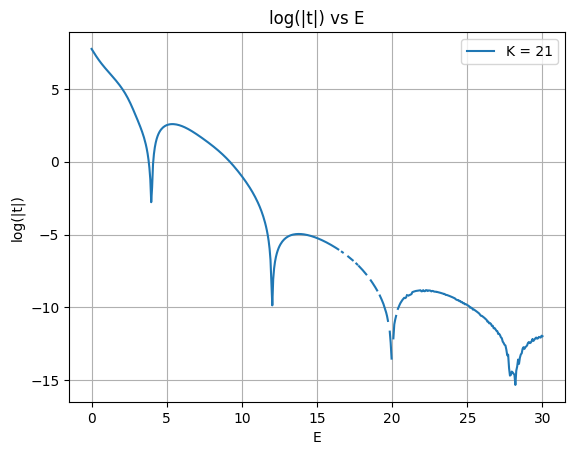

In [159]:
plt.plot(E_vals,np.log(np.abs(t_vals)),label=f'K = {K}')
plt.title('log(|t|) vs E')
plt.xlabel('E')
plt.ylabel('log(|t|)')
plt.legend()
plt.grid()
plt.show()